# <center><strong style="color:#363062">Rainfall Forecast</strong></center>

##### Data Import and Initial Preprocessing

In [217]:
# Import the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

In [218]:
# Read data
date_col = 'Date'
rainfall_col = 'RF_LeThuy'

df = pd.read_csv('data.csv')
df = pd.DataFrame({ 'Date': df[date_col], 'Rainfall': df[rainfall_col] })

In [219]:
# Set the correct data type
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y', errors='coerce')
df['Rainfall'] = pd.to_numeric(df['Rainfall'], errors='coerce')

## <strong style="color:#ff9717"><em>Data Preprocessing</em></strong>

##### Handing Missing Values

Display missing value

In [220]:
# Display missing value
for i in range(len(df.columns)):
  missing_data = df[df.columns[i]].isna().sum()
  print(f'> Column {i}[{df.columns[i]}] missing entries: {missing_data}')

> Column 0[Date] missing entries: 0
> Column 1[Rainfall] missing entries: 3


Fill missing value with mode

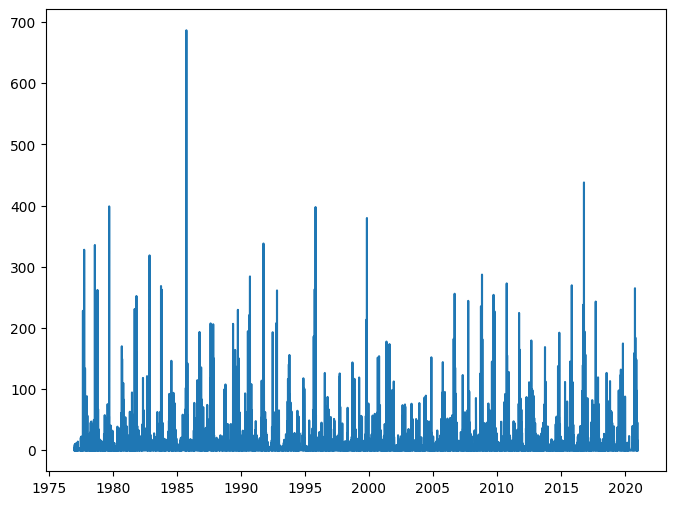

In [221]:
# Fill missing value with mode
mode_value = df['Rainfall'].mode()[0]
df['Rainfall'].fillna(mode_value, inplace=True)

# Plot the data
plt.figure(figsize=(8, 6))
plt.plot(df['Date'], df['Rainfall'])
plt.show()

##### Handing Data Noise

Extract Month from Date and Calculate Monthly Average Rainfall

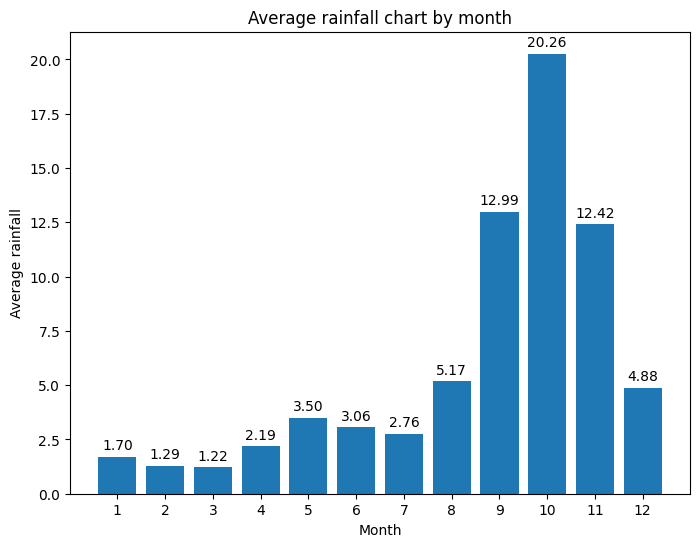

In [222]:
df['Month'] = df['Date'].dt.month
monthly_avg = df.groupby('Month')['Rainfall'].mean()

# Plot the data
plt.figure(figsize=(8, 6))
bars = plt.bar(monthly_avg.index, monthly_avg.values)
plt.xlabel('Month')
plt.ylabel('Average rainfall')
plt.title('Average rainfall chart by month')

for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height), 
    xytext=(0, 3), textcoords='offset points', ha='center', va='bottom')

plt.xticks(range(1, 13))
plt.show()

Filter Data by Month and Rainfall

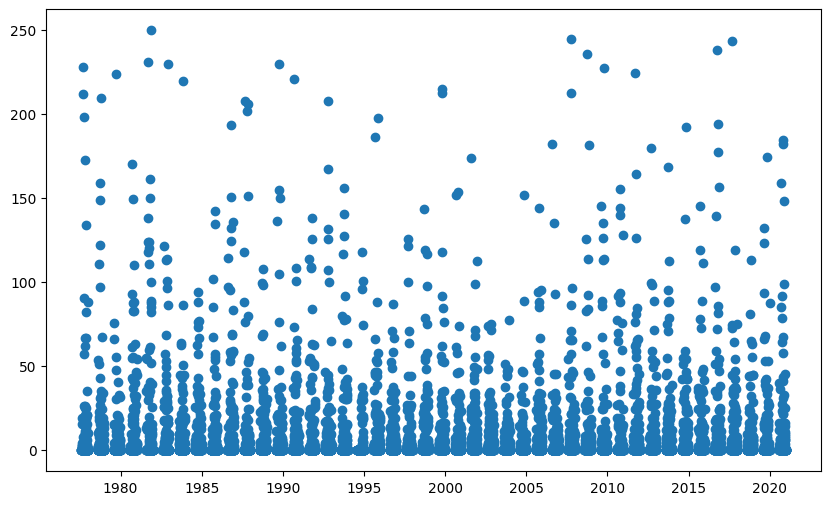

In [223]:
# Split data by month and filter out outliers
data = df[df['Month'].between(8, 12)].copy()
data = data[data['Rainfall'] <= 250]

plt.figure(figsize=(10, 6))
plt.scatter(data['Date'], data['Rainfall'])
plt.show()

data.drop(columns=['Date', 'Month'], axis=1, inplace=True)

##### Data Label Categorization

In [224]:
# Categorize the data into 4 levels
def CategorizeRainFall(y):
  if (y < 16): return 0
  elif (y < 51): return 1
  elif (y <= 100): return 2
  else: return 3

## <strong style="color:#ff9717"><em>Model Building</em></strong>

In [225]:
# Import the libraries
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, accuracy_score, confusion_matrix
import seaborn as sns

SVM Model Building

In [226]:
# Build SVM model
def BuildSVM(X, y):
  SVM = SVC(kernel='sigmoid', decision_function_shape='ovr')
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
  SVM.fit(X_train, y_train)
  return SVM, X_test, y_test

Scoring The SVM Model

In [227]:
# Score SVM model
def ScoreSVM(X, y):
  SVM, X_test, y_test = BuildSVM(X, y)
  y_pred = SVM.predict(X_test)
  precision, recall, f1_score, support = precision_recall_fscore_support(y_test, y_pred, average='macro')
  accuracy = accuracy_score(y_test, y_pred)
  cm = confusion_matrix(y_test, y_pred)
  return precision, recall, f1_score, support, accuracy, cm

Process Data for SVM Model

In [228]:
def ProcessData(data, days):
    dt = data.copy()
    for i in range(days + 1):
        dt[f'{i} Days Before'] = dt['Rainfall'].shift(-i)
    dt.dropna(inplace=True)
    X = dt.drop(['Rainfall'], axis=1)
    y = dt['Rainfall']
    return X, y

Find the Best Number of Days and F1-Score for Model Selection

In [229]:
# Initialize a DataFrame to store the results
res = pd.DataFrame(columns=['Days', 'Precision', 'Recall', 'F1-Score', 'Support', 'Accuracy'])

best_num = None
best_f1_score = 0

for num in range(2, 61):
    X, y = ProcessData(data, num)
    y = y.apply(CategorizeRainFall)

    precision, recall, f1_score, support, accuracy, cm = ScoreSVM(X, y)

    # Store the results in the DataFrame
    res.loc[num] = [num, precision, recall, f1_score, support, accuracy]

    # Check if the current F1-score is better than the best so far
    if f1_score > best_f1_score:
        best_f1_score = f1_score
        best_num = num

print(res)
print(f'Best number of days: {best_num}')
print(f'Best F1-score: {best_f1_score}')

    Days  Precision    Recall  F1-Score  Support  Accuracy
2    2.0   0.375454  0.423773  0.395452      NaN  0.895600
3    3.0   0.369726  0.449886  0.396745      NaN  0.888143
4    4.0   0.350221  0.427337  0.374534      NaN  0.868755
5    5.0   0.325498  0.367203  0.341488      NaN  0.847015
6    6.0   0.381557  0.411783  0.379967      NaN  0.864179
7    7.0   0.501836  0.359879  0.359767      NaN  0.837313
8    8.0   0.506277  0.377621  0.391445      NaN  0.838060
9    9.0   0.470556  0.392889  0.402968      NaN  0.843284
10  10.0   0.489444  0.405789  0.412225      NaN  0.847647
11  11.0   0.473403  0.426585  0.439592      NaN  0.852128
12  12.0   0.444279  0.413088  0.422432      NaN  0.852875
13  13.0   0.470507  0.456551  0.461815      NaN  0.870799
14  14.0   0.455019  0.472803  0.463316      NaN  0.864824
15  15.0   0.475694  0.495462  0.484272      NaN  0.871450
16  16.0   0.486042  0.506147  0.495306      NaN  0.878924
17  17.0   0.459749  0.468360  0.462626      NaN  0.8579

Display Confusion Matrix and Performance Metrics for the Best Model

Days         57.000000
Precision     0.839909
Recall        0.775322
F1-Score      0.804880
Support            NaN
Accuracy      0.899248
Name: 57, dtype: float64


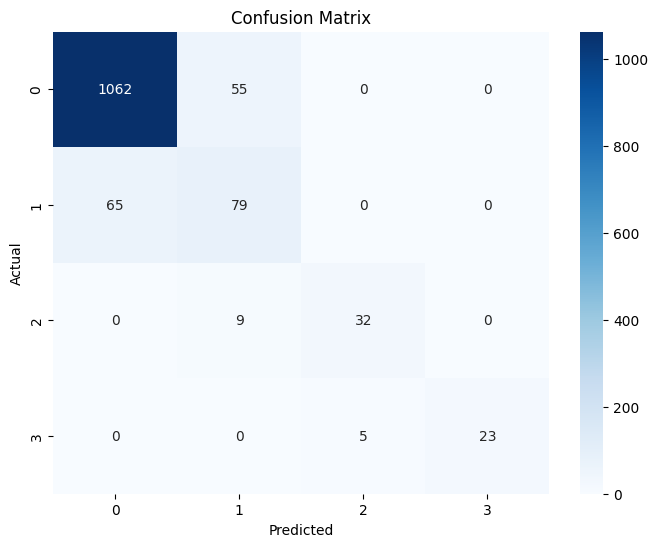

In [230]:
# Print the best model
print(res.loc[best_num])
# Display the confusion matrix of the best model
X, y = ProcessData(data, best_num)
y = y.apply(CategorizeRainFall)
SVM, X_test, y_test = BuildSVM(X, y)
y_pred = SVM.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Visualize Performance Metrics

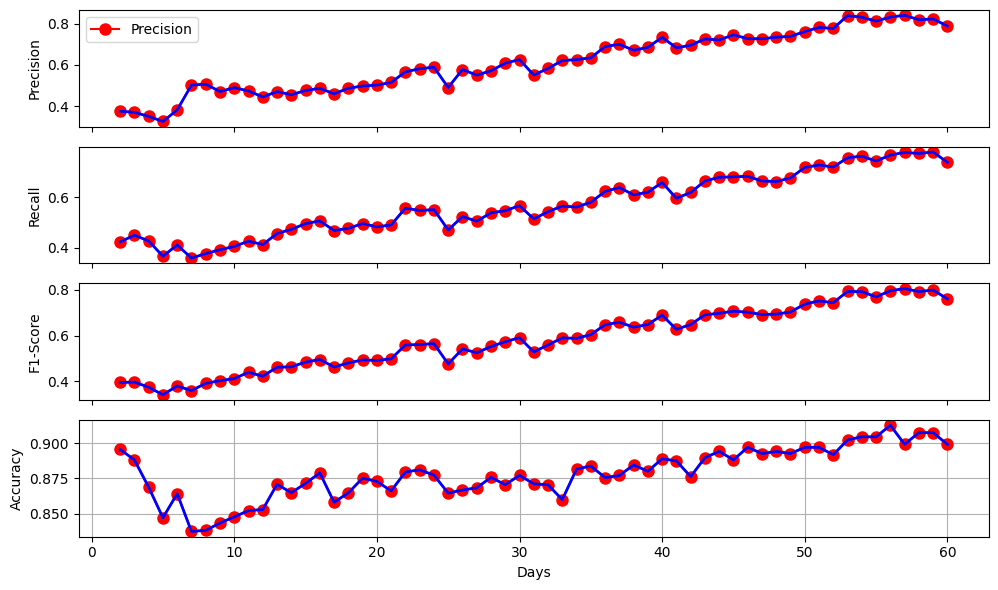

In [231]:
# Create a figure with 4 subplots
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10, 6), sharex=True)

lines = ['Precision', 'Recall', 'F1-Score', 'Accuracy']

for i, line in enumerate(lines):
    axes[i].plot(res['Days'], res[line], marker='o', markersize=8, color='red', label=line)
    axes[i].plot(res['Days'], res[line], linestyle='-', linewidth=2, color='blue')
    axes[i].set_ylabel(line)

axes[-1].set_xlabel('Days')
axes[0].legend()
plt.grid(True)
plt.tight_layout()
plt.show()